In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../scripts")
from time_series_analysis import kpss_test, plot_trends_seasonal, get_switchpt

In [44]:
DATA_FOLDER = '../data'
gas_timeseries = pd.read_csv(f'{DATA_FOLDER}/BrentOilPrices.csv')

In [45]:
gas_timeseries['Date'] = pd.to_datetime(gas_timeseries['Date'], format='mixed')
gas_timeseries.set_index('Date', inplace=True)
gas_timeseries['Price'] = gas_timeseries['Price'].interpolate(method='time')



In [46]:
events = pd.read_csv(f'{DATA_FOLDER}/events.csv')

In [47]:
gas_timeseries.describe()

,Price
count,9011.000000
mean,48.420782
std,32.860110
min,9.100000
25%,19.050000
50%,38.570000
75%,70.090000
max,143.950000


In [48]:
events['Approximate_Start_Date'] = pd.to_datetime(events['Approximate_Start_Date'])

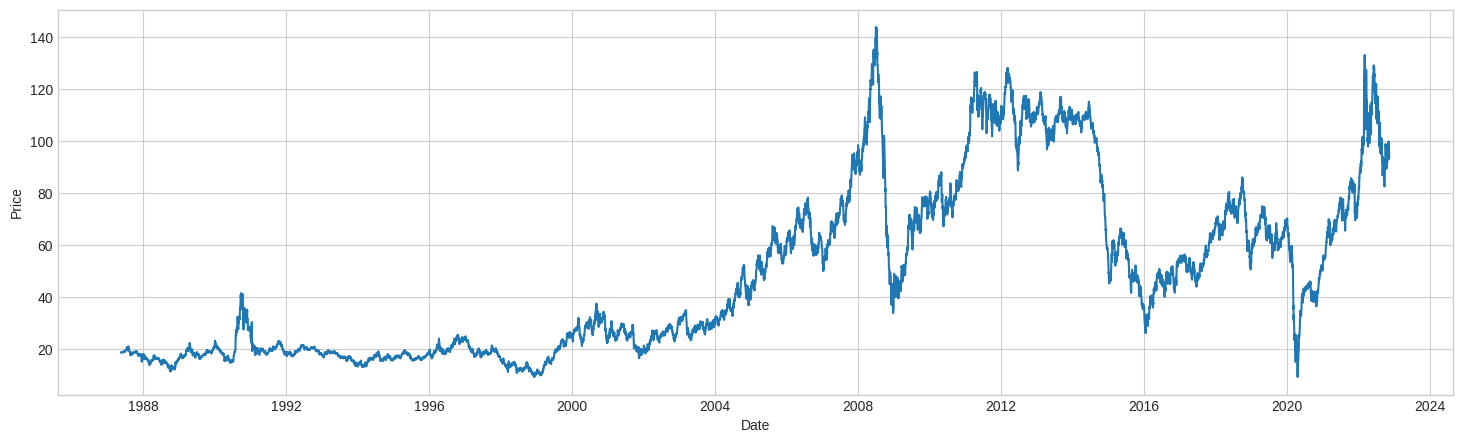

In [49]:

plt.figure(figsize=(18, 5))
sns.lineplot(gas_timeseries, x="Date", y="Price")
plt.show()

In [50]:
events.describe()

,Event_ID,Approximate_Start_Date
count,16.000000,16
mean,8.500000,2011-07-14 00:00:00
min,1.000000,1990-08-02 00:00:00
25%,4.750000,2002-11-01 06:00:00
50%,8.500000,2014-04-24 12:00:00
75%,12.250000,2020-03-19 00:00:00
max,16.000000,2023-10-07 00:00:00
std,4.760952,NaN


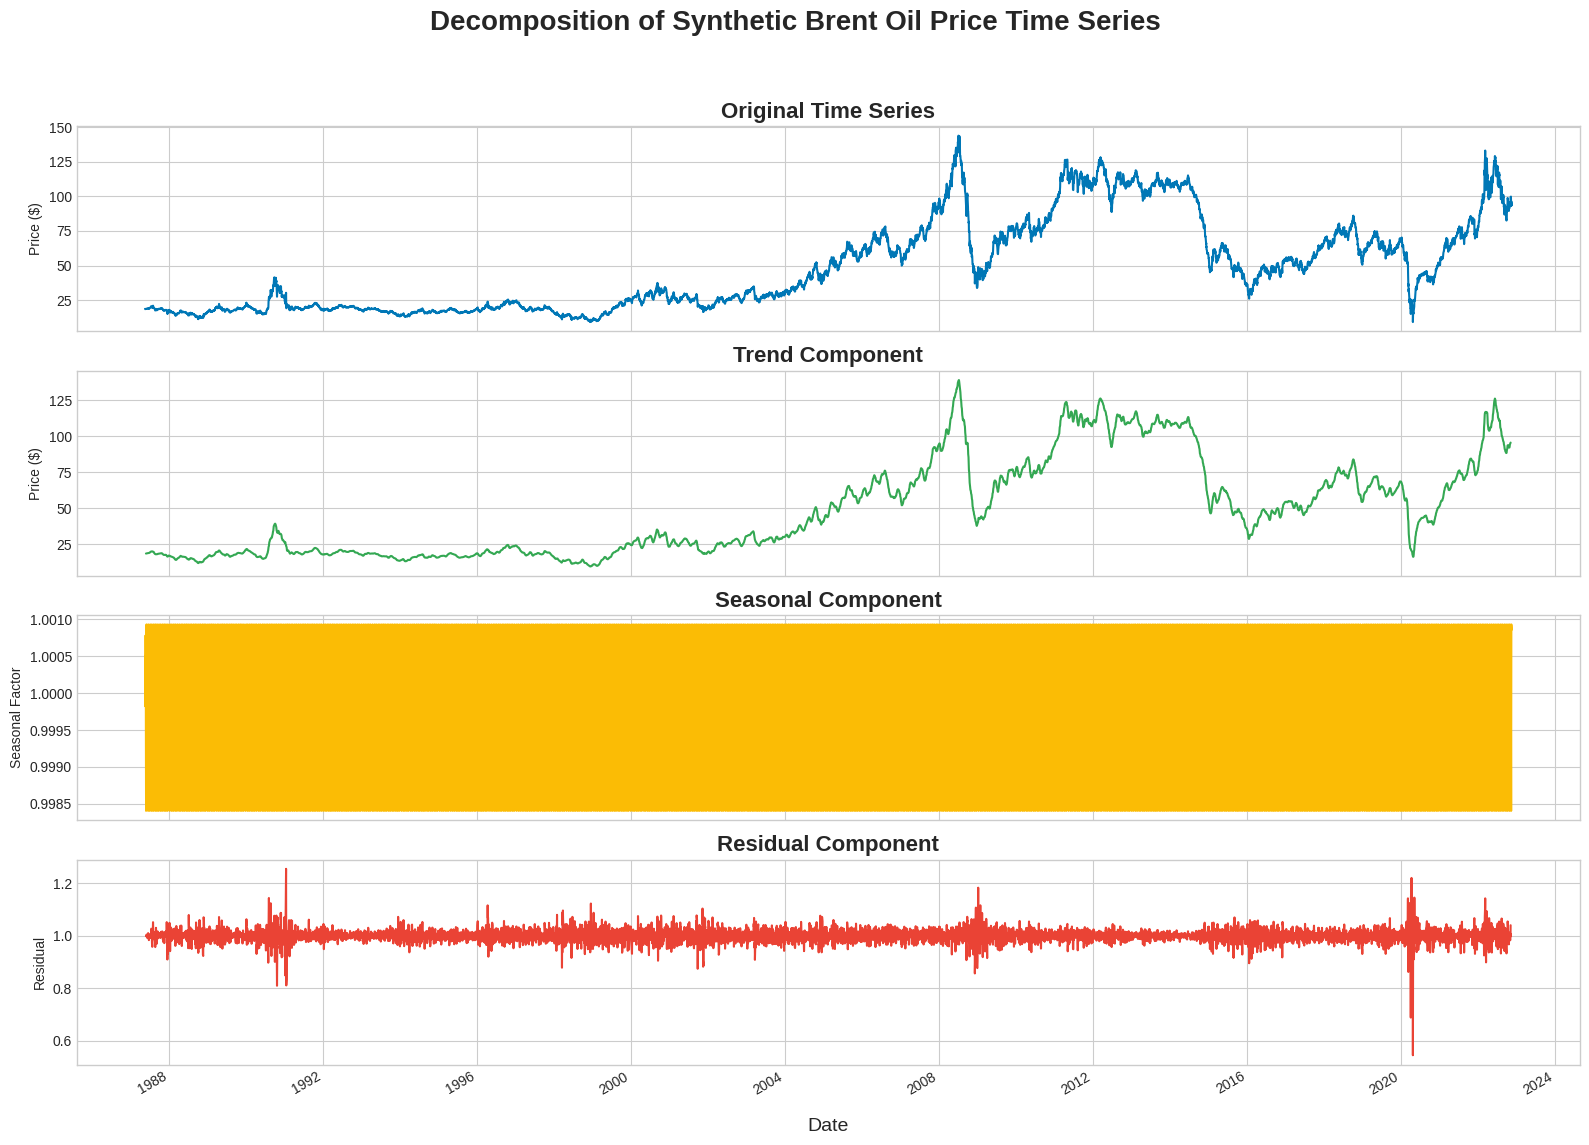

In [51]:
plot_trends_seasonal(gas_timeseries)

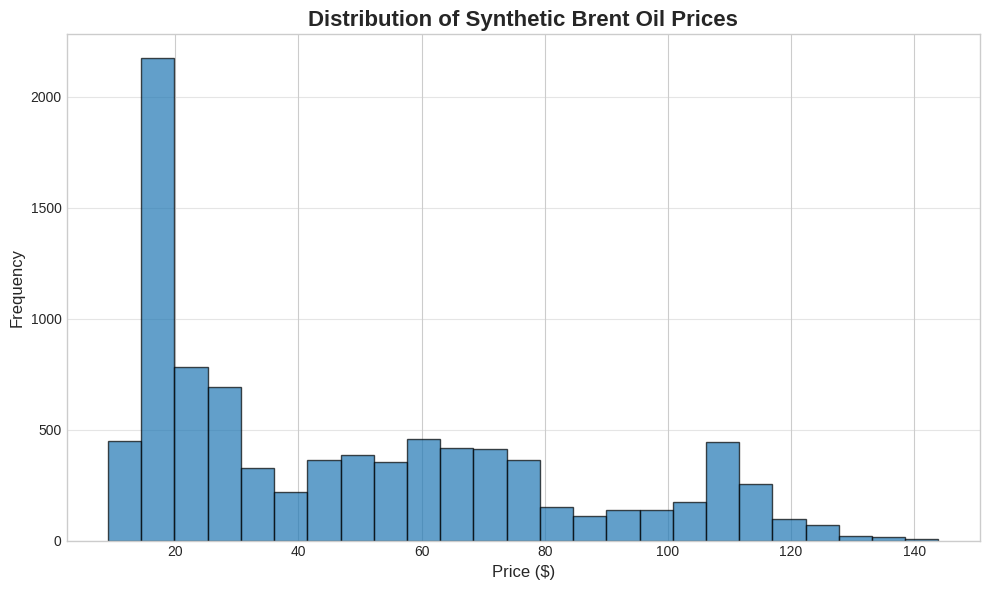

In [52]:
plt.figure(figsize=(10, 6))
plt.hist(gas_timeseries, bins=25,  edgecolor='black', alpha=0.7)
plt.title('Distribution of Synthetic Brent Oil Prices', fontsize=16, fontweight='bold')
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


In [53]:

gas_timeseries['Log_Return'] = np.log(gas_timeseries['Price']).diff().dropna()
price = gas_timeseries['Price'].values.reshape(-1,1)
price_value = gas_timeseries['Price']
kpss_test(price)

likely non-stationary


/home/mikiask/anotherproject/statistical-modelling-of-time-series-data-week-10/notebooks/../scripts/time_series_analysis.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_statistic, p_value, n_lags, critical_values = kpss(timeseries,regression='c')


True

In [ ]:
log_return_price = gas_timeseries['Log_Return'].dropna()
log_return = log_return_price.values
 

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

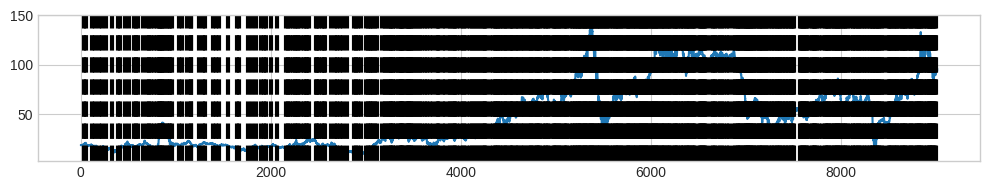

In [55]:
import ruptures as rpt

algo = rpt.Pelt(model="l2", min_size=10)
algo.fit(price)
result = algo.predict(pen=10)
rpt.display(price, [], result)

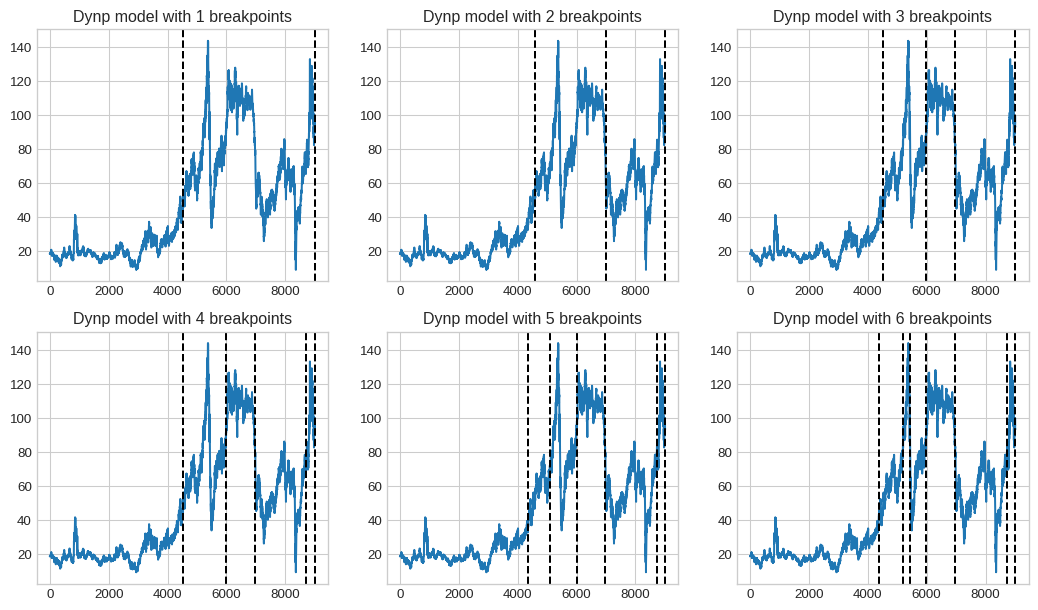

In [56]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3, figsize=(1280/96, 720/96), dpi=96)
ax = ax.ravel()

algo = rpt.Dynp(model="l2", min_size=28)
algo.fit(price)

for i, n_bkps in enumerate([1, 2, 3, 4, 5, 6]):
    result = algo.predict(n_bkps=n_bkps)
    ax[i].plot(price)
    for bkp in result:
        ax[i].axvline(x=bkp, color='k', linestyle='--')
    ax[i].set_title(f"Dynp model with {n_bkps} breakpoints")

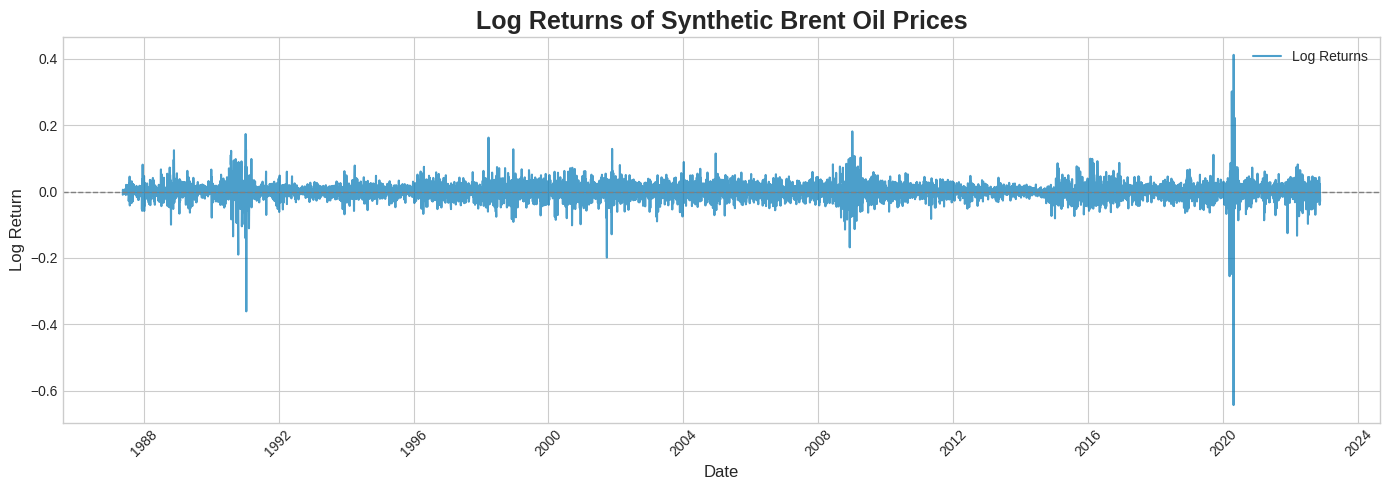

In [57]:
plt.figure(figsize=(14, 5))
plt.plot(gas_timeseries['Log_Return'].index, gas_timeseries['Log_Return'].values, label='Log Returns', color='#0077b6', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Log Returns of Synthetic Brent Oil Prices', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Return', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Defining switchpoint tau

In [58]:

tau = get_switchpt(log_return_price)


In [59]:
import pytensor.tensor as tt
import pymc as pm
with pm.Model() as pmModel:
    tau = pm.DiscreteUniform('tau', lower=0, upper=len(log_return_price)-1)
    time_index = np.arange(len(log_return_price))
    #before and after
    mean_1 = pm.Normal('mean_1', mu=log_return.mean(), sigma=log_return.std() * 2)
    mean_2 = pm.Normal('mean_2', mu=log_return.mean(), sigma=log_return.std() * 2)
    std_1 = pm.HalfNormal('std_1', sigma=log_return.std())
    std_2 = pm.HalfNormal('std_2', sigma=log_return.std())
    mean = pm.math.switch(time_index < tau, mean_1, mean_2)
    std = pm.math.switch(time_index < tau, std_1, std_2)
    mu_log_return = pm.Normal('mu_log_return', mu=0, sigma=0.01)
    observation = pm.Normal("observation", mu=mu_log_return, sigma=std, observed=log_return_price)
    print("\nStarting PyMC sampling for Bayesian Volatility Change Point Detection...")
    trace_volatility = pm.sample(draws=2000, tune=1000, chains=4, random_seed=42, return_inferencedata=True, cores=1)
    print("PyMC Sampling Complete.")


Starting PyMC sampling for Bayesian Volatility Change Point Detection...


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mean_1, mean_2, std_1, std_2, mu_log_return]


/home/mikiask/anotherproject/statistical-modelling-of-time-series-data-week-10/.venv/lib/python3.13/site-packages/r
ich/live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.


PyMC Sampling Complete.


### Check for Convergence

In [60]:
pm.summary(trace_volatility)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5389.279,21.568,5345.000,5421.000,0.722,0.488,997.0,1164.0,1.0
mean_1,-0.000,0.051,-0.099,0.092,0.000,0.001,13526.0,6765.0,1.0
mean_2,0.000,0.052,-0.094,0.100,0.000,0.001,12555.0,6485.0,1.0
mu_log_return,0.000,0.000,-0.000,0.001,0.000,0.000,12188.0,6486.0,1.0
std_1,0.023,0.000,0.023,0.023,0.000,0.000,13137.0,6289.0,1.0
std_2,0.029,0.000,0.028,0.030,0.000,0.000,11867.0,6723.0,1.0


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'mean_1'}>,
        <Axes: title={'center': 'mean_1'}>],
       [<Axes: title={'center': 'mean_2'}>,
        <Axes: title={'center': 'mean_2'}>],
       [<Axes: title={'center': 'mu_log_return'}>,
        <Axes: title={'center': 'mu_log_return'}>],
       [<Axes: title={'center': 'std_1'}>,
        <Axes: title={'center': 'std_1'}>],
       [<Axes: title={'center': 'std_2'}>,
        <Axes: title={'center': 'std_2'}>]], dtype=object)

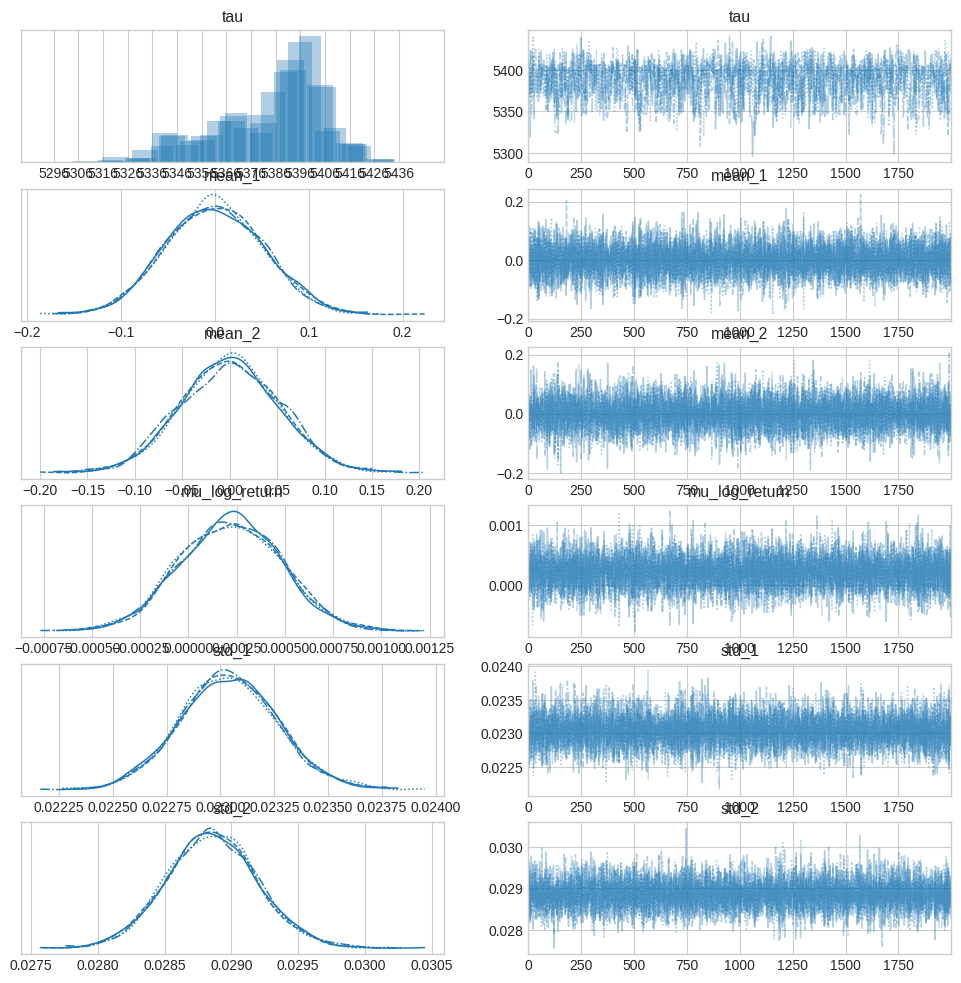

In [61]:

pm.plot_trace(trace_volatility)


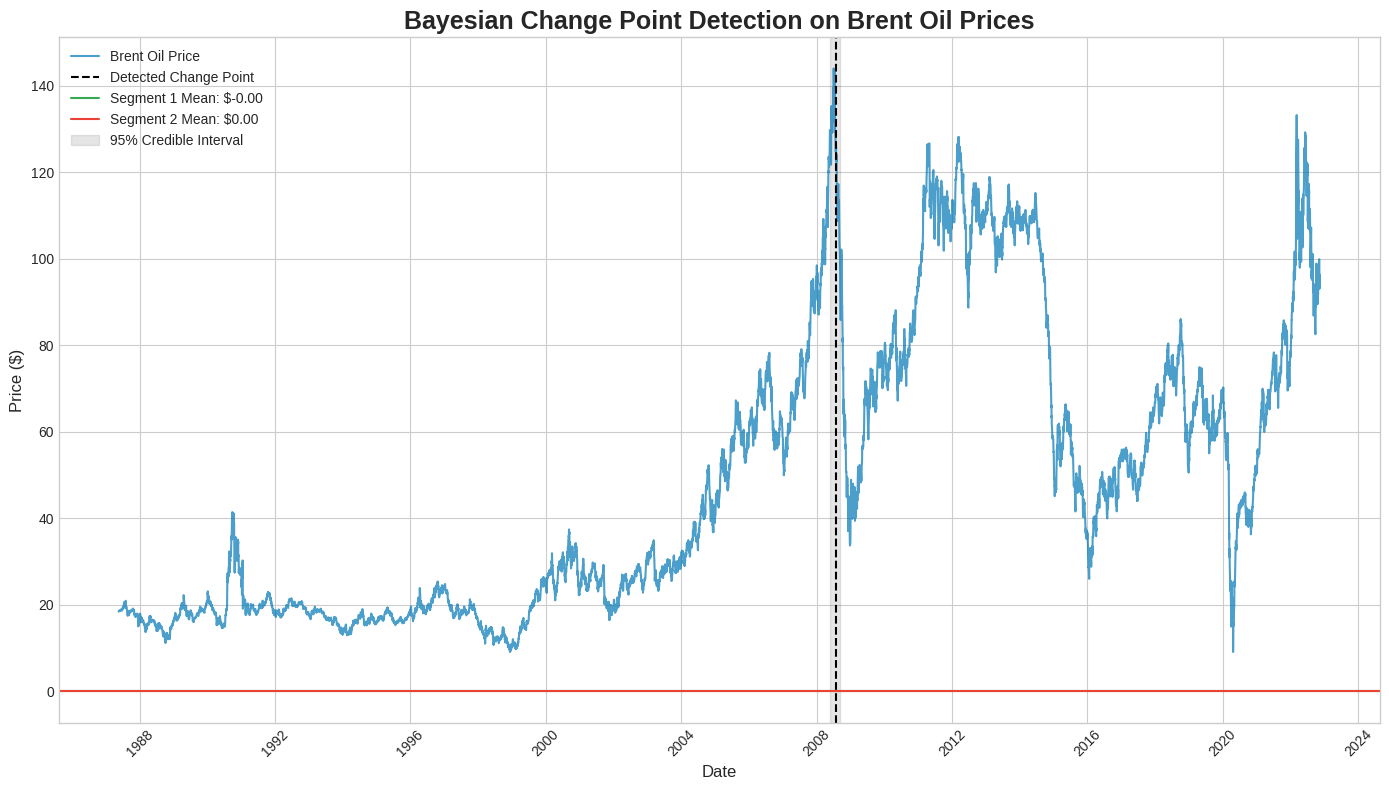

In [62]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the original oil price data
ax.plot(price_value.index, price_value.values, label='Brent Oil Price', color='#0077b6', alpha=0.7)

# Get the posterior mean of the change point and its index
tau_post = trace_volatility.posterior['tau'].mean().item()
tau_index = int(tau_post)
change_point_date = price_value.index[tau_index]

# Plot the detected change point as a vertical line
ax.axvline(x=change_point_date, color='black', linestyle='--', label=f'Detected Change Point')

# Get the posterior mean of the parameters for plotting the segmented fit
mean_1_post = trace_volatility.posterior['mean_1'].mean().item()
mean_2_post = trace_volatility.posterior['mean_2'].mean().item()
ax.axhline(y=mean_1_post, color='#34a853', linestyle='-', label=f'Segment 1 Mean: ${mean_1_post:.2f}')
ax.axhline(y=mean_2_post, color='#ea4335', linestyle='-', label=f'Segment 2 Mean: ${mean_2_post:.2f}')

# Plot the credible interval for the change point location
# Ensure 'tau' is treated as a 1D array for az.hdi if it's not already
tau_hdi = pm.hdi(trace_volatility, var_names=['tau'])['tau'].values
hpd_dates = [price_value.index[int(tau_hdi[0])], price_value.index[int(tau_hdi[1])]]
ax.axvspan(hpd_dates[0], hpd_dates[1], color='gray', alpha=0.2, label='95% Credible Interval')

ax.set_title(f'Bayesian Change Point Detection on Brent Oil Prices', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price ($)', fontsize=12)
ax.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Identify the Change Point

<Figure size 1000x600 with 0 Axes>

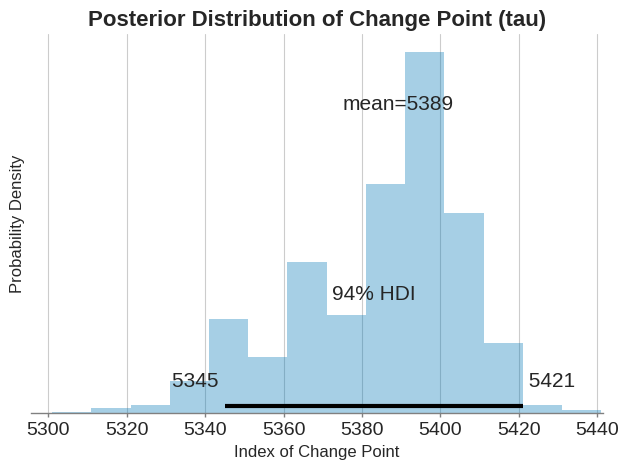

In [65]:
import arviz as az
plt.figure(figsize=(10, 6))
az.plot_posterior(trace_volatility, var_names=['tau'], kind='hist', color='#0077b6')
plt.title('Posterior Distribution of Change Point (tau)', fontsize=16, fontweight='bold')
plt.xlabel('Index of Change Point', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.tight_layout()
plt.show()

## Quantifying the Impact: Posterior Distributions


--- Quantifying the Impact: Posterior Distributions ---


<Figure size 1200x600 with 0 Axes>

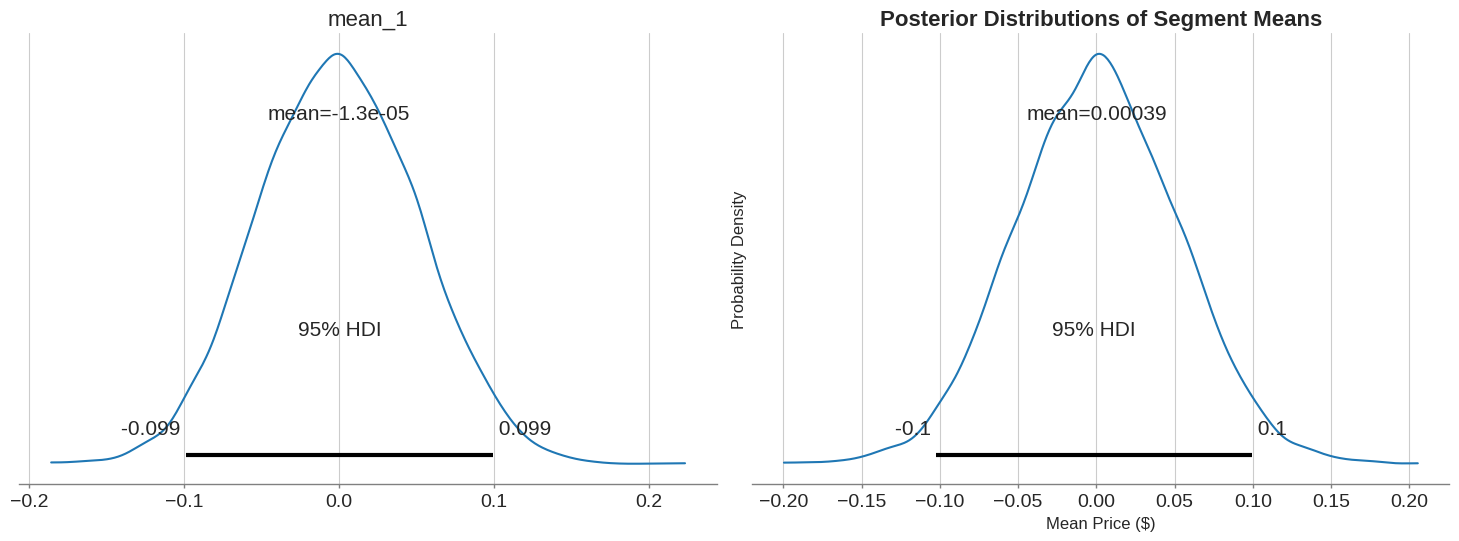

<Figure size 1200x600 with 0 Axes>

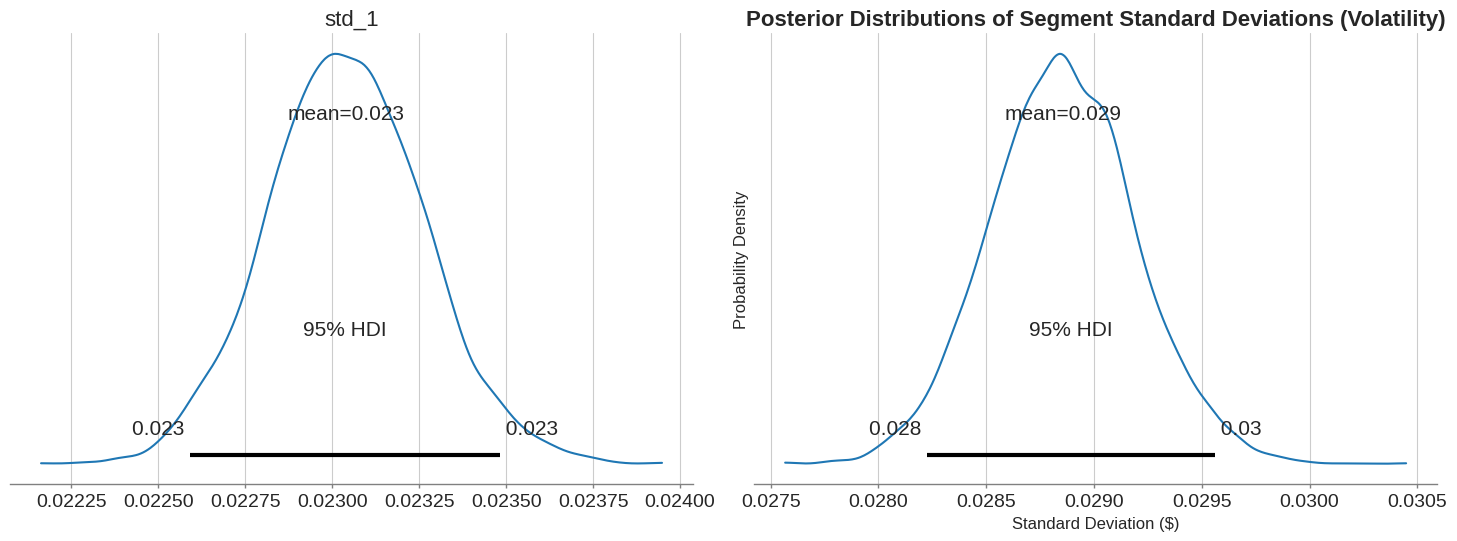

Probability that the mean price AFTER the change point is higher than BEFORE: 50.50%
Probability that volatility AFTER the change point is higher than BEFORE: 100.00%


In [67]:
print("\n--- Quantifying the Impact: Posterior Distributions ---")

# Plot posterior distributions for means
plt.figure(figsize=(12, 6))
az.plot_posterior(trace_volatility, var_names=['mean_1', 'mean_2'], kind='kde', hdi_prob=0.95)
plt.title('Posterior Distributions of Segment Means', fontsize=16, fontweight='bold')
plt.xlabel('Mean Price ($)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.tight_layout()
plt.show()

# Plot posterior distributions for standard deviations (volatility)
plt.figure(figsize=(12, 6))
az.plot_posterior(trace_volatility, var_names=['std_1', 'std_2'], kind='kde', hdi_prob=0.95)
plt.title('Posterior Distributions of Segment Standard Deviations (Volatility)', fontsize=16, fontweight='bold')
plt.xlabel('Standard Deviation ($)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate and print probabilities of increase/decrease
# Probability that mean_2 is greater than mean_1
prob_mean_increase = (trace_volatility.posterior['mean_2'] > trace_volatility.posterior['mean_1']).mean().item()
print(f"Probability that the mean price AFTER the change point is higher than BEFORE: {prob_mean_increase:.2%}")

# Probability that sd_2 is greater than sd_1 (volatility increase)
prob_sd_increase = (trace_volatility.posterior['std_2'] > trace_volatility.posterior['std_1']).mean().item()
print(f"Probability that volatility AFTER the change point is higher than BEFORE: {prob_sd_increase:.2%}")